# *Imports*

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Importar Adam

from xgboost import XGBRegressor

import optuna # Para tuning da ANN


# **1. Load and Prepare Data** 

In [77]:
df = pd.read_csv("../data/processed/agg_data_ml.csv")
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data').reset_index(drop=True) # Sort and reset index


X = df.drop(columns=['Data', 'Eólica'])
y = df['Eólica']


# Using 80% for training + validation, 20% for testing
split_index = int(len(df) * 0.8)
X_train_val_orig, X_test_orig = X.iloc[:split_index], X.iloc[split_index:]
y_train_val_orig, y_test_orig = y.iloc[:split_index], y.iloc[split_index:]


X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

## *Scaling (Required for ANN)*


In [79]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers ONLY on the original training+validation data
X_train_val_scaled = scaler_X.fit_transform(X_train_val_orig)
y_train_val_scaled = scaler_y.fit_transform(y_train_val_orig.values.reshape(-1, 1))

# Transform the test data using the fitted scalers
X_test_scaled = scaler_X.transform(X_test_orig)
# y_test is kept unscaled for final evaluation, y_test_scaled needed if evaluating ANN loss directly

# --- 4. Further Split for ANN Validation ---
# Split the scaled training+validation data into training and validation sets for ANN
# Using roughly 85% of train_val for training ANN (~68% overall), 15% for validation (~12% overall)
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
    X_train_val_scaled, y_train_val_scaled, test_size=0.15, random_state=42
)

# **2. Train Models and Generate Predictions**

In [43]:
predictions = {}
models_trained = {}

## **ExtraTrees**


In [44]:
et_model = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1)
et_model.fit(X_train_val_orig, y_train_val_orig)
predictions['ExtraTrees'] = et_model.predict(X_test)
models_trained['ExtraTrees'] = et_model


## **RandomForest**


In [45]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_train_val_orig, y_train_val_orig) 
predictions['RandomForest'] = rf_model.predict(X_test)
models_trained['RandomForest'] = rf_model

## **Gradient Boosting** 


In [46]:
gb_model = GradientBoostingRegressor(n_estimators=500, random_state=42)
gb_model.fit(X_train_val_orig, y_train_val_orig)
predictions['GradientBoosting'] = gb_model.predict(X_test)
models_trained['GradientBoosting'] = gb_model

## **XGBoost**


In [47]:
xgb_model = XGBRegressor(n_estimators=500, random_state=42, verbosity=0, n_jobs=-1)
xgb_model.fit(X_train_val_orig, y_train_val_orig)
predictions['XGBoost'] = xgb_model.predict(X_test)
models_trained['XGBoost'] = xgb_model

## **ANN**

In [48]:
ann_model = Sequential([
    Input((X_train_ann.shape[1],)),
    # Dense(64, activation='relu', ),
    # Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)


In [49]:
history = ann_model.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_val_ann, y_val_ann),
    epochs=200,     
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1034 - mae: 0.2435 - val_loss: 0.0337 - val_mae: 0.1433
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - mae: 0.1512 - val_loss: 0.0263 - val_mae: 0.1246
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - mae: 0.1337 - val_loss: 0.0224 - val_mae: 0.1138
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - mae: 0.1285 - val_loss: 0.0197 - val_mae: 0.1072
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - mae: 0.1214 - val_loss: 0.0177 - val_mae: 0.1013
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - mae: 0.1177 - val_loss: 0.0159 - val_mae: 0.0955
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - mae: 0.1095 - val_loss: 0.0144 - val_mae: 0.0902
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - mae: 0.0994 - val_loss: 0.0134 - val_mae: 0.0876
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.017

In [50]:

y_pred_scaled_ann = ann_model.predict(X_test_scaled, verbose=0)
predictions['ANN'] = scaler_y.inverse_transform(y_pred_scaled_ann).flatten() # flatten array
models_trained['ANN'] = ann_model

## *Results*


--- Comparison DataFrame (First 5 rows) ---
      Eolica_Real  Eolica_Pred_ExtraTrees  Eolica_Pred_RandomForest  \
3213     123195.1             105059.2682               107394.5250   
3214     155748.0             107566.5046               110247.9060   
3215     183423.7             199286.4184               198551.1818   
3216     178352.1             180638.6324               181293.2120   
3217      60869.3              75162.5282                71609.7096   

      Eolica_Pred_GradientBoosting  Eolica_Pred_XGBoost  Eolica_Pred_ANN  
3213                 107977.404967        127094.031250    113744.710938  
3214                 103317.032423        106265.882812     82367.500000  
3215                 209854.759963        187479.125000    195448.156250  
3216                 192626.102925        181992.562500    195786.687500  
3217                  64104.740041         70001.429688     85400.523438  

--- Comparison DataFrame (Last 5 rows) ---
      Eolica_Real  Eolica_Pred_Ext

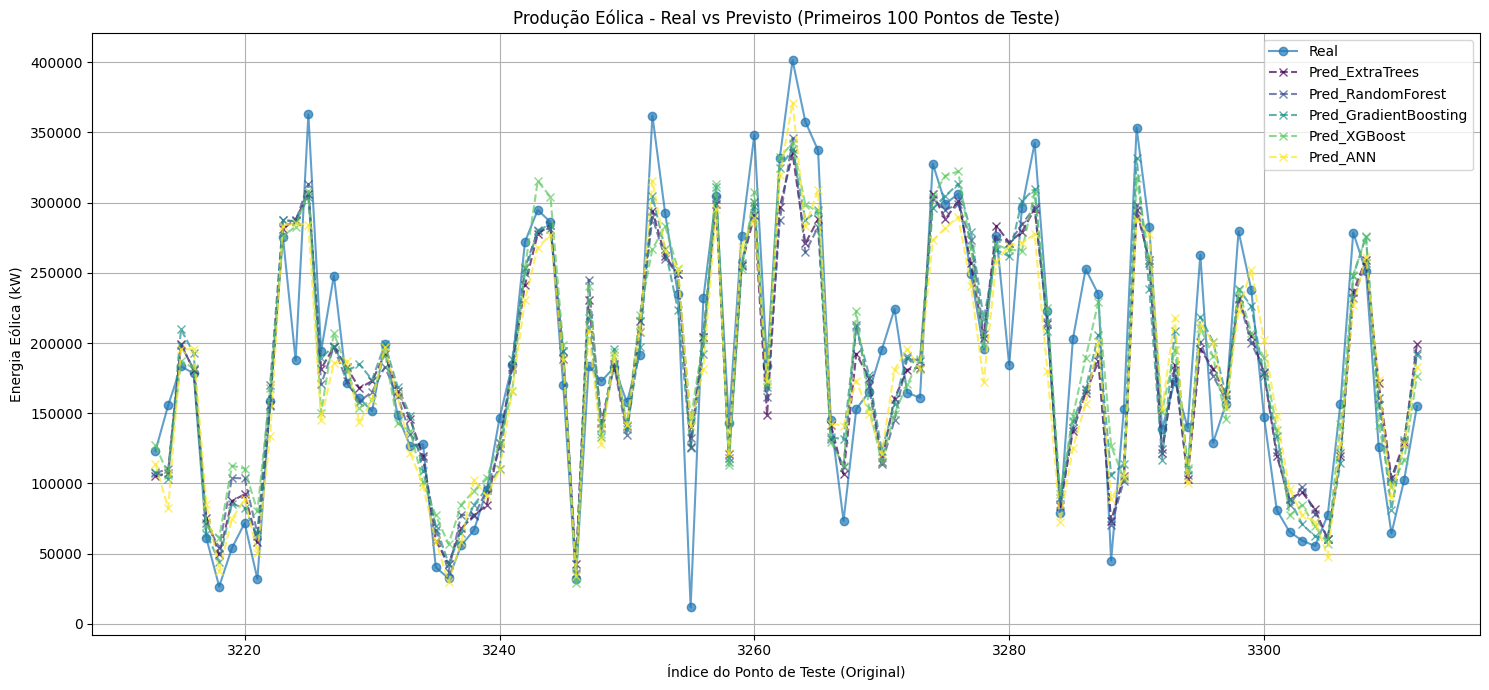

In [51]:
comparison_df = pd.DataFrame({'Eolica_Real': y_test.values}, index=y_test.index)

for model_name, preds in predictions.items():
    # Ensure predictions align with y_test index
    comparison_df[f'Eolica_Pred_{model_name}'] = pd.Series(preds, index=y_test.index)

print("\n--- Comparison DataFrame (First 5 rows) ---")
print(comparison_df.head())
print("\n--- Comparison DataFrame (Last 5 rows) ---")
print(comparison_df.tail())



metrics = {}
for model_name, preds in predictions.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    y_test_safe = y_test.copy()
    y_test_safe[y_test_safe == 0] = 1e-6 # Replace 0 with a small epsilon to avoid division by zero
    mape = mean_absolute_percentage_error(y_test_safe, preds) * 100
    metrics[model_name] = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

metrics_df = pd.DataFrame(metrics).T # Transpose for better readability

print("\n--- Evaluation Metrics ---")
print(metrics_df)


plt.figure(figsize=(15, 7))
plt.plot(comparison_df.index[:100], comparison_df['Eolica_Real'][:100], label='Real', marker='o', linestyle='-', alpha=0.7)

colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))

for i, (model_name, preds) in enumerate(predictions.items()):
    plt.plot(comparison_df.index[:100], comparison_df[f'Eolica_Pred_{model_name}'][:100],
             label=f'Pred_{model_name}', marker='x', linestyle='--', alpha=0.7, color=colors[i])

plt.title('Produção Eólica - Real vs Previsto (Primeiros 100 Pontos de Teste)')
plt.xlabel('Índice do Ponto de Teste (Original)')
plt.ylabel('Energia Eólica (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **Overall Performance**: R² values are all around 0.80-0.83. This is reasonably good, indicating the models capture a significant portion of the variance. RMSE and MAE values are in the 30,000-40,000 range (likely kWh based on previous context). MAPE is around 37-38%.
- **Best Performers**: RandomForest and ExtraTrees (both bagging ensembles) seem slightly better on R², MAE, and RMSE. Gradient Boosting and ANN are close behind. XGBoost is slightly lower in R² but comparable in MAE/RMSE/MAPE.
- **MAPE**: The MAPE values are relatively high (37-38%). This suggests that while the R² is decent, the percentage error can still be substantial, especially possibly on days with lower production (where the denominator in MAPE is small).
- **Consistency**: The models are performing relatively similarly. There isn't one standout winner by a huge margin, suggesting the current features and basic model structures might be hitting a plateau.

# **3. Hyperparameter tuning**

## **Gradient Boosting Tuning w/ RandomizedSearchCV**

In [53]:
# Define o espaço de parâmetros para procurar
param_dist_gb = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0] # Fração de amostras para treinar cada árvore
}

gb = GradientBoostingRegressor(random_state=42)

# Cross-validation temporal
# n_splits controla quantas divisões treino/validação serão feitas
# Aumentar n_splits dá mais robustez, mas aumenta o tempo de execução
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search
# n_iter controla quantas combinações aleatórias de parâmetros serão testadas
# Aumentar n_iter melhora a chance de encontrar bons parâmetros, mas aumenta o tempo
n_iter_search = 30 # Podes aumentar para 50 ou 100 se tiveres tempo
random_search_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist_gb,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_mean_absolute_error', # Maximiza o MAE negativo (minimiza MAE)
    n_jobs=-1, # Usar todos os cores disponíveis
    random_state=42,
    verbose=1 # Mostra progresso
)

# Executar a procura nos dados de treino+validação (não escalados para GB)
print("A executar RandomizedSearch para Gradient Boosting...")
random_search_gb.fit(X_train_val_orig, y_train_val_orig)

print("\nMelhores Hiperparâmetros para Gradient Boosting:")
print(random_search_gb.best_params_)
print(f"Melhor Score (Negative MAE) na Validação Cruzada: {random_search_gb.best_score_:.4f}")

# --- Treinar Modelo Final GB com Melhores Parâmetros ---
print("\nA treinar modelo final Gradient Boosting com melhores parâmetros...")
best_gb_model = GradientBoostingRegressor(**random_search_gb.best_params_, random_state=42)
best_gb_model.fit(X_train_val_orig, y_train_val_orig)

# --- Avaliar no Conjunto de Teste ---
print("\nA avaliar Gradient Boosting otimizado no conjunto de teste...")
y_pred_gb_tuned = best_gb_model.predict(X_test)

r2_gb_tuned = r2_score(y_test, y_pred_gb_tuned)
mae_gb_tuned = mean_absolute_error(y_test, y_pred_gb_tuned)
rmse_gb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_gb_tuned))
y_test_safe = y_test.copy()
y_test_safe[y_test_safe == 0] = 1e-6 # Evitar divisão por zero no MAPE
mape_gb_tuned = mean_absolute_percentage_error(y_test_safe, y_pred_gb_tuned) * 100

print("\nMétricas Gradient Boosting Otimizado:")
print(f"  R2:   {r2_gb_tuned:.6f}")
print(f"  MAE:  {mae_gb_tuned:.2f}")
print(f"  RMSE: {rmse_gb_tuned:.2f}")
print(f"  MAPE: {mape_gb_tuned:.2f}%")

A executar RandomizedSearch para Gradient Boosting...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Melhores Hiperparâmetros para Gradient Boosting:
{'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.05}
Melhor Score (Negative MAE) na Validação Cruzada: -21996.0873

A treinar modelo final Gradient Boosting com melhores parâmetros...

A avaliar Gradient Boosting otimizado no conjunto de teste...

Métricas Gradient Boosting Otimizado:
  R2:   0.897446
  MAE:  23063.22
  RMSE: 30082.39
  MAPE: 24.62%


## **XGBoost Tuning w/ RandomizedSearchCV**

In [54]:
param_dist_xgb = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],  
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  
    'gamma': [0, 0.1, 0.5, 1],           
    'reg_alpha': [0, 0.01, 0.1, 1],        
    'reg_lambda': [0.1, 0.5, 1, 2]
}

# Modelo base
xgb = XGBRegressor(random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1) # objective comum para regressão

# Cross-validation temporal (reutilizar tscv ou redefinir se necessário)
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search
n_iter_search = 40 # Pode precisar de mais iterações devido a mais parâmetros
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Executar a procura nos dados de treino+validação (não escalados para XGB)
print("A executar RandomizedSearch para XGBoost...")
random_search_xgb.fit(X_train_val_orig, y_train_val_orig)

print("\nMelhores Hiperparâmetros para XGBoost:")
print(random_search_xgb.best_params_)
print(f"Melhor Score (Negative MAE) na Validação Cruzada: {random_search_xgb.best_score_:.4f}")

# --- Treinar Modelo Final XGB com Melhores Parâmetros ---
print("\nA treinar modelo final XGBoost com melhores parâmetros...")
best_xgb_model = XGBRegressor(**random_search_xgb.best_params_, random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1)
best_xgb_model.fit(X_train_val_orig, y_train_val_orig)

# --- Avaliar no Conjunto de Teste ---
print("\nA avaliar XGBoost otimizado no conjunto de teste...")
y_pred_xgb_tuned = best_xgb_model.predict(X_test)

r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
y_test_safe = y_test.copy()
y_test_safe[y_test_safe == 0] = 1e-6
mape_xgb_tuned = mean_absolute_percentage_error(y_test_safe, y_pred_xgb_tuned) * 100

print("\nMétricas XGBoost Otimizado:")
print(f"  R2:   {r2_xgb_tuned:.6f}")
print(f"  MAE:  {mae_xgb_tuned:.2f}")
print(f"  RMSE: {rmse_xgb_tuned:.2f}")
print(f"  MAPE: {mape_xgb_tuned:.2f}%")

A executar RandomizedSearch para XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Melhores Hiperparâmetros para XGBoost:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Melhor Score (Negative MAE) na Validação Cruzada: -21938.7584

A treinar modelo final XGBoost com melhores parâmetros...

A avaliar XGBoost otimizado no conjunto de teste...

Métricas XGBoost Otimizado:
  R2:   0.894720
  MAE:  23444.45
  RMSE: 30479.60
  MAPE: 25.34%


## **ANN Tuning w/ Optuna**

In [66]:
def create_ann_model_optuna(trial):
    # Definir hiperparâmetros a otimizar pelo Optuna
    neurons1 = trial.suggest_categorical('neurons1', [32, 64, 128, 256])
    neurons2 = trial.suggest_categorical('neurons2', [16, 32, 64, 128])
    neurons3 = trial.suggest_categorical('neurons3', [8, 16, 32]) # Adicionar uma terceira camada?
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5, step=0.1)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation_func = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu']) # Experimentar ativações

    model = Sequential([
        Input((X_train_ann.shape[1],)),
        Dense(neurons1, activation=activation_func), # Usar input_shape do X_train_val_scaled
        Dropout(dropout_rate1),
        Dense(neurons2, activation=activation_func),
        Dropout(dropout_rate2),
        # Dense(neurons3, activation=activation_func), # Terceira camada opcional
        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def objective_ann(trial):
    # Cross-validation temporal DENTRO do Optuna
    tscv = TimeSeriesSplit(n_splits=4) # Menos splits para acelerar o tuning
    val_maes = []

    for train_idx, val_idx in tscv.split(X_train_val_scaled):
        X_train_fold, X_val_fold = X_train_val_scaled[train_idx], X_train_val_scaled[val_idx]
        y_train_fold, y_val_fold = y_train_val_scaled[train_idx], y_train_val_scaled[val_idx]

        model = create_ann_model_optuna(trial)

        # Early stopping para cada fold
        early_stop_optuna = EarlyStopping(
            monitor='val_mae',
            patience=30, # Menor paciência durante o tuning
            restore_best_weights=True
        )

        model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=150, # Menos épocas para o tuning
            batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
            callbacks=[early_stop_optuna],
            verbose=0 # Silenciar output do fit
        )

        # Avaliar no fold de validação
        loss, mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_maes.append(mae)

        # Informar Optuna sobre passos intermédios (opcional, para prunning)
        trial.report(mae, step=len(val_maes))
        # Verificar se o trial deve ser parado (prunning)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Retorna a média do MAE nos folds de validação (queremos minimizar)
    return np.mean(val_maes)

In [ ]:
study_ann = optuna.create_study(direction='minimize') # Minimizar o MAE médio da validação

# Executar a otimização
# n_trials controla quantas combinações Optuna vai tentar
study_ann.optimize(objective_ann, n_trials=5) # Aumenta n_trials para uma busca melhor

print("\nMelhor Trial ANN:")
trial = study_ann.best_trial
print(f"  Valor (MAE médio validação): {trial.value:.6f}")
print("  Melhores Hiperparâmetros:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params_ann = trial.params
# Precisamos recriar o modelo com os melhores parâmetros encontrados
# Nota: Optuna pode escolher diferentes parâmetros a cada execução,
# por isso precisamos extrair os melhores 'neurons', 'dropout', etc.
final_ann_model = Sequential([
    Input((X_train_ann.shape[1],)),
    Dense(best_params_ann['neurons1'], activation=best_params_ann['activation']),
    Dropout(best_params_ann['dropout_rate1']),
    Dense(best_params_ann['neurons2'], activation=best_params_ann['activation']),
    Dropout(best_params_ann['dropout_rate2']),
    Dense(best_params_ann['neurons3'], activation=best_params_ann['activation']),
    Dense(1, activation='linear')
])
final_optimizer = Adam(learning_rate=best_params_ann['learning_rate'])
final_ann_model.compile(optimizer=final_optimizer, loss='mean_squared_error', metrics=['mae'])

# Treinar no conjunto completo de treino+validação (escalado)
# Usar EarlyStopping com mais paciência para o treino final
final_early_stop = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, verbose=1)

# Precisamos de um split treino/validação final para o callback
X_train_ann_final, X_val_ann_final, y_train_ann_final, y_val_ann_final = train_test_split(
    X_train_val_scaled, y_train_val_scaled, test_size=0.15, random_state=42 # Mesmo split usado no tuning
)


[I 2025-05-06 10:24:35,768] A new study created in memory with name: no-name-0b8fe8bd-b46f-4a68-a4cc-fecff5bd6ec7


A executar Otimização Optuna para ANN (pode demorar)...


[I 2025-05-06 10:29:52,311] Trial 0 finished with value: 0.0640443479642272 and parameters: {'neurons1': 256, 'neurons2': 16, 'neurons3': 8, 'dropout_rate1': 0.4, 'dropout_rate2': 0.2, 'learning_rate': 0.00890462026997674, 'activation': 'relu', 'batch_size': 16}. Best is trial 0 with value: 0.0640443479642272.
[I 2025-05-06 10:38:35,454] Trial 1 finished with value: 0.05511321872472763 and parameters: {'neurons1': 32, 'neurons2': 128, 'neurons3': 32, 'dropout_rate1': 0.5, 'dropout_rate2': 0.5, 'learning_rate': 0.0005659139905353598, 'activation': 'tanh', 'batch_size': 16}. Best is trial 1 with value: 0.05511321872472763.
[I 2025-05-06 10:56:58,941] Trial 2 finished with value: 0.051574558950960636 and parameters: {'neurons1': 32, 'neurons2': 32, 'neurons3': 16, 'dropout_rate1': 0.5, 'dropout_rate2': 0.2, 'learning_rate': 0.002074595528136214, 'activation': 'tanh', 'batch_size': 16}. Best is trial 2 with value: 0.051574558950960636.
[I 2025-05-06 11:02:47,606] Trial 3 finished with valu


Melhor Trial ANN:
  Valor (MAE médio validação): 0.051575
  Melhores Hiperparâmetros:
    neurons1: 32
    neurons2: 32
    neurons3: 16
    dropout_rate1: 0.5
    dropout_rate2: 0.2
    learning_rate: 0.002074595528136214
    activation: tanh
    batch_size: 16

A treinar modelo final ANN com melhores parâmetros...


In [68]:

history_final = final_ann_model.fit(
    X_train_ann_final, y_train_ann_final,
    validation_data=(X_val_ann_final, y_val_ann_final),
    epochs=300, # Aumentar épocas para o treino final
    batch_size=best_params_ann['batch_size'],
    callbacks=[final_early_stop],
    verbose=1 # Ver progresso do treino final
)

# --- Avaliar no Conjunto de Teste ---
print("\nA avaliar ANN otimizada no conjunto de teste...")
y_pred_ann_scaled_tuned = final_ann_model.predict(X_test_scaled, verbose=0)
y_pred_ann_tuned = scaler_y.inverse_transform(y_pred_ann_scaled_tuned).flatten()

r2_ann_tuned = r2_score(y_test, y_pred_ann_tuned)
mae_ann_tuned = mean_absolute_error(y_test, y_pred_ann_tuned)
rmse_ann_tuned = np.sqrt(mean_squared_error(y_test, y_pred_ann_tuned))
y_test_safe = y_test.copy()
y_test_safe[y_test_safe == 0] = 1e-6
mape_ann_tuned = mean_absolute_percentage_error(y_test_safe, y_pred_ann_tuned) * 100

print("\nMétricas ANN Otimizada:")
print(f"  R2:   {r2_ann_tuned:.6f}")
print(f"  MAE:  {mae_ann_tuned:.2f}")
print(f"  RMSE: {rmse_ann_tuned:.2f}")
print(f"  MAPE: {mape_ann_tuned:.2f}%")

Epoch 1/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1142 - mae: 0.2564 - val_loss: 0.0305 - val_mae: 0.1439
Epoch 2/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0388 - mae: 0.1550 - val_loss: 0.0239 - val_mae: 0.1231
Epoch 3/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0310 - mae: 0.1394 - val_loss: 0.0200 - val_mae: 0.1146
Epoch 4/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0266 - mae: 0.1298 - val_loss: 0.0145 - val_mae: 0.0963
Epoch 5/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208 - mae: 0.1140 - val_loss: 0.0106 - val_mae: 0.0798
Epoch 6/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171 - mae: 0.1006 - val_loss: 0.0099 - val_mae: 0.0787
Epoch 7/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155 - mae: 0.0970 - val_loss: 0.0093 - val_mae: 0.0722
Epoch 8/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0142 - mae: 0.0926 - val_loss: 0.0069 - val_mae: 0.0627
Epoch 9/300
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9